In [2]:
# Import 
import os
import time
import json
import datetime
import pandas as pd
import numpy as np

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline

vispy  won't work


In [3]:
import sys
sys.path.append("..")

In [4]:
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.toolbox import modify_some_initial_settings


In [5]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

In [6]:
!pwd

/home/lglepin/peripodial/notebook


In [7]:


dsets = hdf5.load_datasets('../json_hdf5/super_eggs_polarity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/super_eggs_polarity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
modify_some_initial_settings(sheet)
geom.scale(sheet, 1 / sheet.face_df.area.mean()**0.5, list("xyz"))
geom.update_all(sheet)


In [8]:
sheet.face_df.prefered_perimeter = 3.80

In [9]:
sheet.face_df.area.mean()

1.0

In [10]:
sheet.settings["lumen_vol"]

5653.012070539491

In [11]:
sheet.specs["face"]["area"]

1.0

In [12]:
sheet.settings

{'geometry': 'spherical',
 'height_axis': 'z',
 'lumen_prefered_vol': 5600,
 'lumen_vol_elasticity': 1e-05,
 'threshold_length': 0.1,
 'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
 'barrier_radius': 100,
 'apopto_pattern_kwargs': {'t': 0.0,
  'dt': 1.0,
  'time_of_last_apoptosis': 30.0},
 'apoptosis': {'critical_area_pulling': 10,
  'critical_area': 0.5,
  'contract_rate': 1.08,
  'basal_contract_rate': 1.01,
  'contract_neighbors': True,
  'contract_span': 3,
  'radial_tension': 50.0,
  'max_traction': 30.0,
  'current_traction': 0.0,
  'geom': polarity.dynamics.EllipsoidLameGeometry},
 'contraction_lt_kwargs': {'face_id': -1,
  'face': -1,
  'shrink_rate': 1.05,
  'critical_area': 5.0,
  'contraction_column': 'line_tension',
  'model': tyssue.dynamics.factory.model_factory.<locals>.NewModel},
 'delaminate_setting': {'radial_tension': 80,
  'contract_rate': 1.08,
  'critical_area_pulling': 15,
  'critical_area': 0.01,
  'current_traction': 0,
  'max_tractio

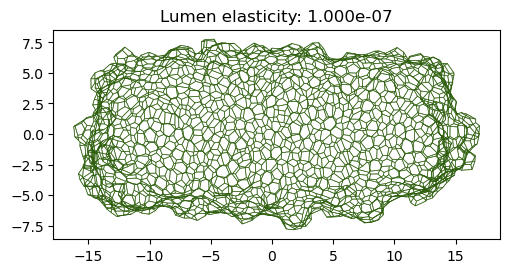

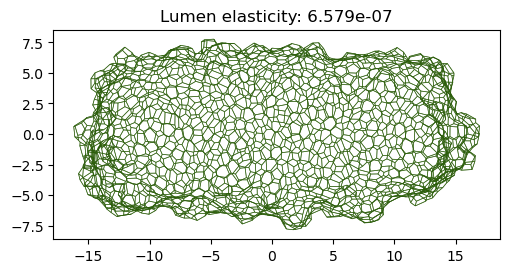

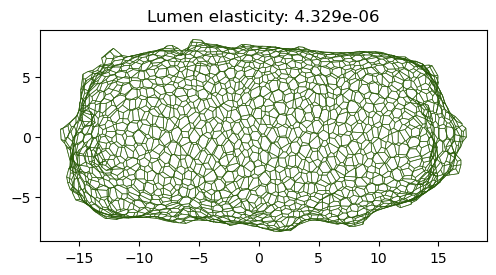

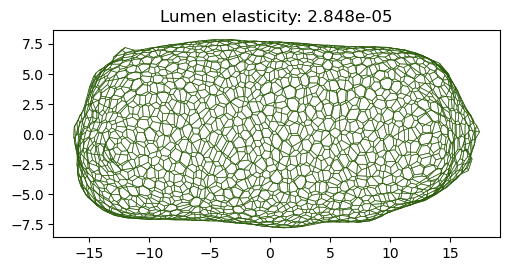

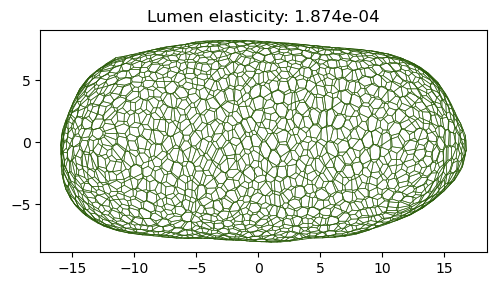

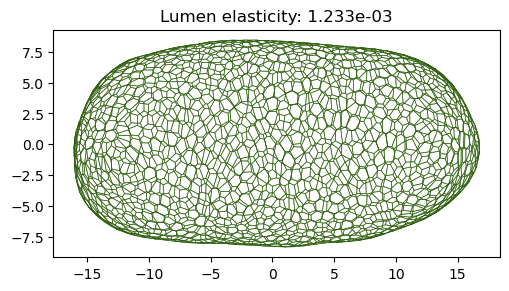

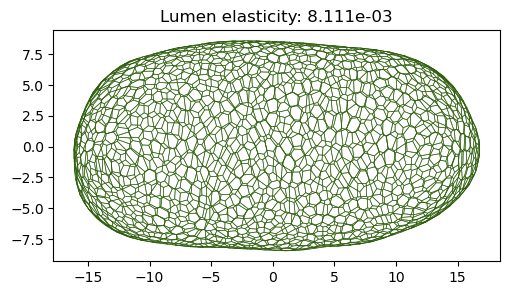

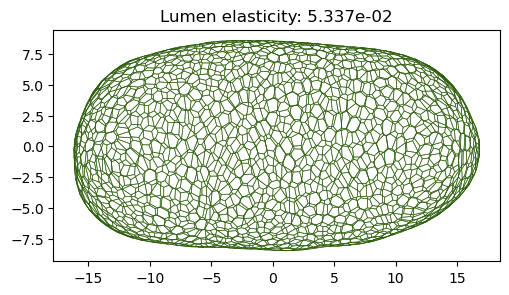

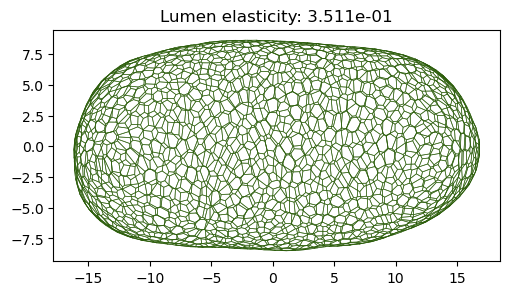

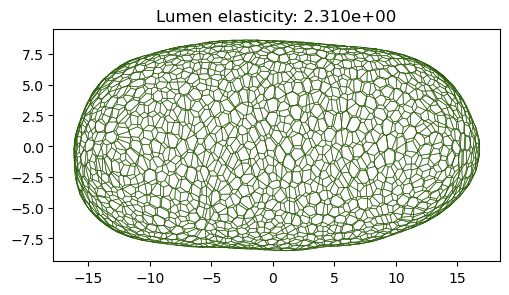

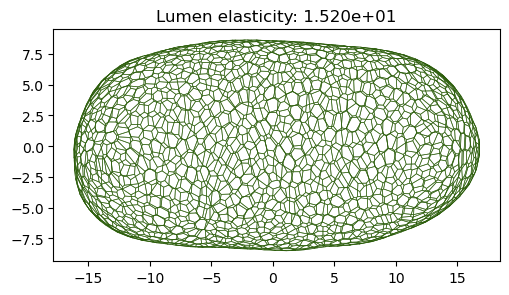

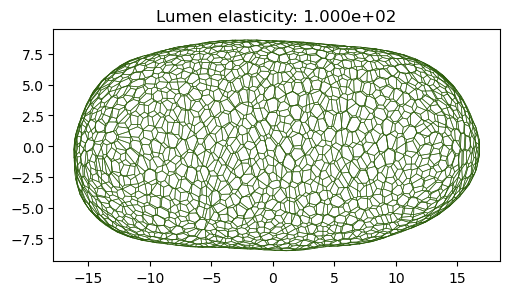

In [13]:
elasticity_values = []
lumen_volume_values = [] 
area_cell_values = [] 
sheet_copy = sheet.copy()

elasticity_values = np.logspace(-7, 2, 12)
for value in elasticity_values:
    sheet_copy.settings["lumen_prefered_vol"] = 5660
    sheet_copy.settings["lumen_vol_elasticity"] = value
    geom.update_all(sheet_copy)
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    fig, ax = sheet_view(sheet_copy, coords=["z", "x"])
    lumen_volume = sheet_copy.settings["lumen_vol"]
    area_cell = sheet_copy.face_df["area"].mean()
    ax.set_title(f"Lumen elasticity: {value:.3e}")
    lumen_volume_values.append(lumen_volume)
    area_cell_values.append(area_cell)

lumen_volume_values = np.array(lumen_volume_values)
area_cell_values = np.array(area_cell_values)

In [14]:
elasticity_values

array([1.00000000e-07, 6.57933225e-07, 4.32876128e-06, 2.84803587e-05,
       1.87381742e-04, 1.23284674e-03, 8.11130831e-03, 5.33669923e-02,
       3.51119173e-01, 2.31012970e+00, 1.51991108e+01, 1.00000000e+02])

In [13]:
sheet_copy.face_df.area.mean()

1.0056476514268822

In [14]:
lumen_volume_values

array([3724.39442002, 3724.39537163, 4541.35532098, 4852.47592823,
       5064.89942378, 5369.55764215, 5594.0185459 , 5650.104098  ,
       5658.66836788, 5659.75507535, 5659.95752795, 5659.99444509])

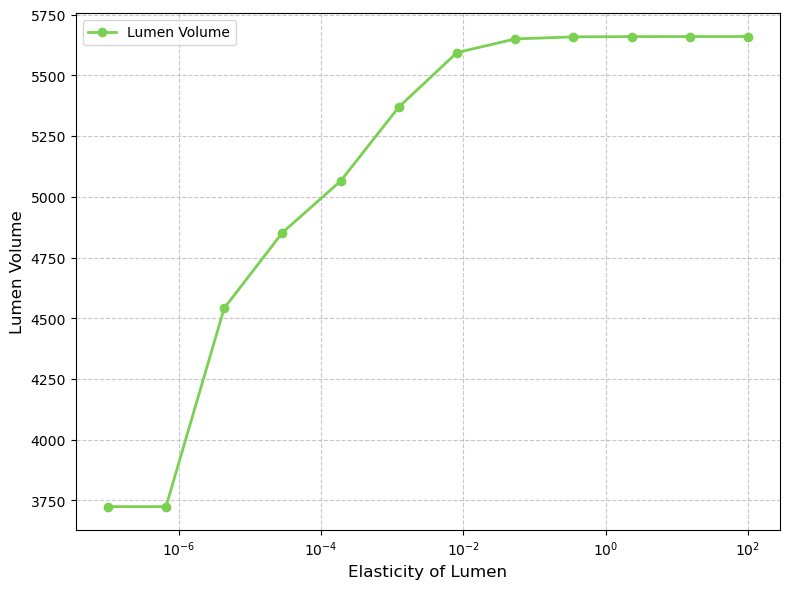

In [18]:
import matplotlib.pyplot as plt

# Generate a list of colors for better visualization
colors = plt.cm.viridis_r([0.2, 0.6])

# Create the plot
fig, axs = plt.subplots(1, figsize=(8, 6))

# Plot lumen_volume_values
axs.plot(elasticity_values, lumen_volume_values, label='Lumen Volume', color=colors[0], marker='o', linestyle='-', linewidth=2)

# Set x-axis to logarithmic scale
axs.set_xscale('log')

# Set labels for x and y axes
axs.set_xlabel('Elasticity of Lumen', fontsize=12)
axs.set_ylabel('Lumen Volume', fontsize=12)

# Add a grid for better readability
axs.grid(True, linestyle='--', alpha=0.7)

# Set the legend
axs.legend(loc='best', fontsize=10)

# Tight layout to prevent overlap of labels
plt.tight_layout()
plt.savefig('../image/lumen_vol_elasticity_lumen.png', transparent=False)
# Show the plot
plt.show()


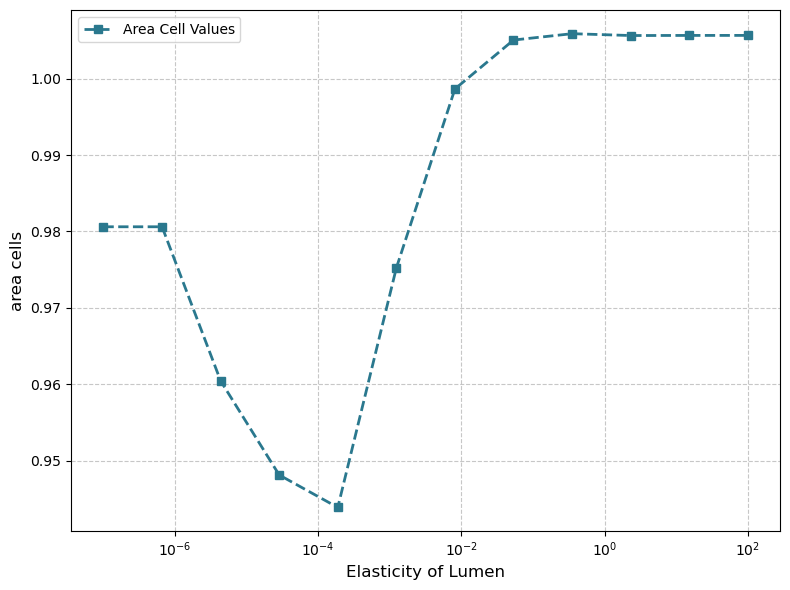

In [15]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(elasticity_values, area_cell_values, label='Area Cell Values', color=colors[1], marker='s', linestyle='--', linewidth=2)
axs.set_xscale('log')
axs.set_xlabel('Elasticity of Lumen', fontsize=12)
axs.set_ylabel('area cells', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/area_cell_elasticity_lumen.png', transparent=False)
plt.show()

In [16]:
print (lumen_volume_values)

[3670.80221727 3682.80034424 4587.77560207 4885.80877692 5030.4211031
 5363.72006015 5591.96192237 5649.08699373 5658.28343194 5659.71386698
 5659.96353379 5659.99338005]


In [25]:
specs['vert'] = {"toto": 280}
sheet.update_specs(specs, reset=True)

In [26]:
specs

{'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'toto': 280}}

In [19]:
specs = {'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'barrier_elasticity': 280}}

In [20]:
sheet.update_specs(specs, reset=True)
res = solver.find_energy_min(sheet, geom, model, options={"gtol":1e-4})


In [21]:
specs

{'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'barrier_elasticity': 280}}

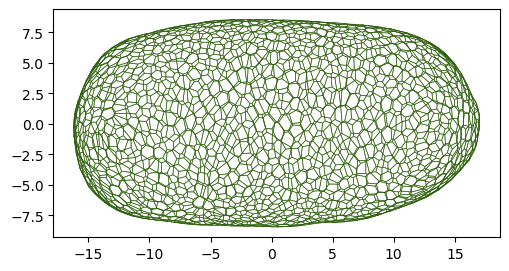

In [22]:
Sheet_ellips = sheet_view(sheet, coords=["z", "x"])

In [23]:
from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/lumen_elasticity.hdf5", sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/lumen_elasticity.json", overwrite=True)